# Detecting deforestation in the Amazon rainforest using unsupervised K-means clustering on satellite imagery

## Table of Contents <a class="anchor" id="0"></a>
* [Introduction](#1) 
* [Imports](#2)
* [Connecting to ArcGIS](#3)
* [Accessing & Visualizing the datasets](#4) 
* [Data Preparation](#5) 
* [Model Building](#9)
    * [Data Preprocessing](#11)  
    * [Model Initialization ](#12)
    * [Learning Rate Search ](#13)
    * [Model Training ](#14) 
    * [Result Visualization](#16)
* [Conclusion](#23)
* [Summary of methods used](#24)
* [Data resources](#25)

## Introduction <a class="anchor" id="1"></a>

Deforestation around the world has acquired a critical level causing irreversible damage to environmental sustainability, 
 which is contributing to climate change across the world. Widespread forest fires from the Amazon basin in Brazil, to the US west coast of California are raging all around the year. In context of this scenario here unsupervised learning is used to detect deforested areas from  satellite images, in the Amazon rainforest in Brazil.

## Imports <a class="anchor" id="2"></a>

In [1]:
%matplotlib inline

import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.display import HTML
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


import arcgis
from arcgis.gis import GIS
from arcgis.learn import MLModel, prepare_tabulardata
from arcgis.raster.functions import apply, clip, remap, colormap
from arcgis.raster import Raster
from fastai.vision import *

## Connecting to ArcGIS <a class="anchor" id="3"></a>

In [2]:
gis = GIS(profile="your_online_profile")
gis2 = GIS(profile="your_enterprise_profile")

## Accessing & Visualizing datasets  <a class="anchor" id="4"></a>

Here Sentinel-2 imagery is used which has a high resolution of 10m and has 13 bands. This imagery is accessed from the ArcGIS Enterprise portal where it is sourced from AWS collection. 

<Item title:"Sentinel-2 Views" type:Imagery Layer owner:esri>
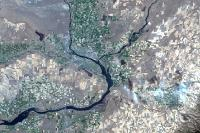

In [4]:
# get image
s2 = gis.content.get('fd61b9e0c69c4e14bebd50a9a968348c')
sentinel = s2.layers[0]
s2

## Define Area of Interest in the Amazon
The area of interest is defined using the four latittude and longitude values from a certain region in the Amazon rainforest where a considerable forest area has been deforested, as can be seen from the images.

In [6]:
#  extent in 3857 for amazon rainforest
amazon_extent = {
    "xmin": -6589488.51,
    "ymin": -325145.08,
    "xmax": -6586199.09,
    "ymax": -327024.74,
    "spatialReference": {"wkid": 3857}
}

Here we select all the scenes from the sentinel imagery containing the area of interest for the study.

In [7]:
# The respective scene having the above area is selected
selected = sentinel.filter_by(where="(Category = 1)",
                              geometry=arcgis.geometry.filters.intersects(amazon_extent))
df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear",
                   order_by_fields="AcquisitionDate").sdf

df['AcquisitionDate'] = pd.to_datetime(df['acquisitiondate'], unit='ms')
df

,objectid,acquisitiondate,groupname,cloudcover,dayofyear,shape_Length,shape_Area,SHAPE,AcquisitionDate
0,8882278,2019-12-04 14:23:29,20191204T142328_21MTS_0,0.3020,338,438802.801081,1.203411e+10,"{""rings"": [[[-6535992.3057, -302418.3759999983...",2019-12-04 14:23:29
1,9467718,2019-12-09 14:23:32,20191209T142331_21MTS_0,0.1343,343,438802.801081,1.203411e+10,"{""rings"": [[[-6535992.3057, -302418.3759999983...",2019-12-09 14:23:32
2,8973682,2019-12-14 14:23:29,20191214T142329_21MTS_0,0.7246,348,438802.801081,1.203411e+10,"{""rings"": [[[-6535992.3057, -302418.3759999983...",2019-12-14 14:23:29
3,9017938,2019-12-19 14:23:29,20191219T142328_21MTS_0,0.7838,353,438802.801081,1.203411e+10,"{""rings"": [[[-6535992.3057, -302418.3759999983...",2019-12-19 14:23:29
4,9063853,2019-12-24 14:23:30,20191224T142329_21MTS_0,0.4687,358,438802.801081,1.203411e+10,"{""rings"": [[[-6535992.3057, -302418.3759999983...",2019-12-24 14:23:30
...,...,...,...,...,...,...,...,...,...
80,13512757,2021-01-12 14:23:36,20210112T142335_21MTS_0,0.9747,12,438802.801081,1.203411e+10,"{""rings"": [[[-6535992.3057, -302418.3759999983...",2021-01-12 14:23:36
81,13557513,2021-01-17 14:23:35,20210117T142334_21MTS_0,0.2624,17,438802.801081,1.203411e+10,"{""rings"": [[[-6535992.3057, -302418.3759999983...",2021-01-17 14:23:35
82,13608514,2021-01-22 14:23:36,20210122T142335_21MTS_0,0.7199,22,438802.801081,1.203411e+10,"{""rings"": [[[-6535992.3057, -302418.3759999983...",2021-01-22 14:23:36
83,13657431,2021-01-27 14:23:35,20210127T142334_21MTS_0,0.9777,27,438802.801081,1.203411e+10,"{""rings"": [[[-6535992.3057, -302418.3759999983...",2021-01-27 14:23:35


The satellite imagery with the least cloud cover is selected and visualized for further processing.

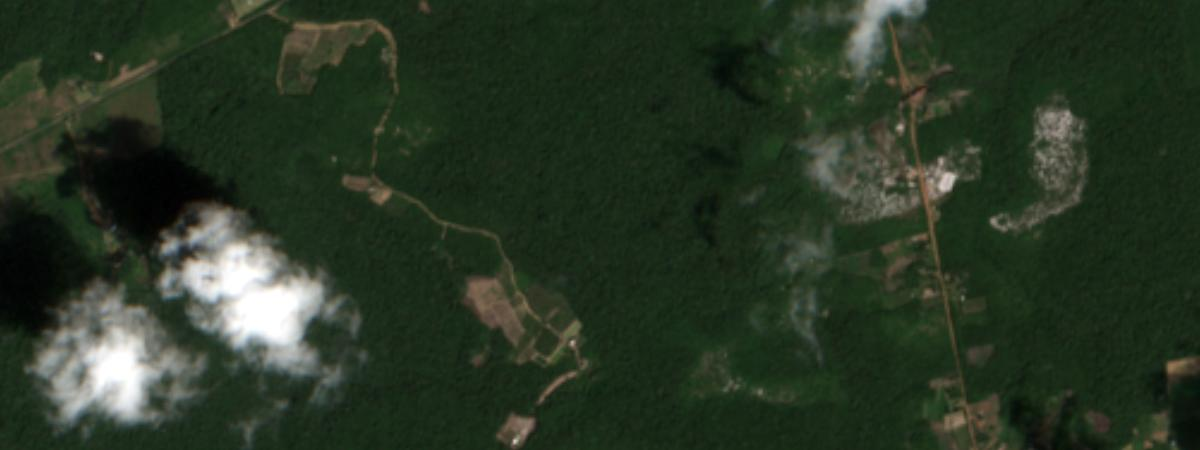

In [8]:
# The scene is selected with a comparitively low cloud cover and extracted using the amzon extent
tile1 = sentinel.filter_by('OBJECTID=13421575')
tile1.extent = amazon_extent
tile1

In the above scene, the brown patches are the deforested areas which has to be identified here.  

In [11]:
# checking the raster information of band counts and pixel size
tile1.raster_info

{'extent': {'xmin': -20037507.0672,
  'ymin': -10100724.094800003,
  'xmax': 20037492.9328,
  'ymax': 14571225.905199997,
  'spatialReference': {'wkid': 102100, 'latestWkid': 3857}},
 'bandCount': 13,
 'pixelType': 'U16',
 'pixelSizeX': 10,
 'pixelSizeY': 10}

## Data Preparation  <a class="anchor" id="5"></a>

Sentinel-2 imagery has 13 bands, out of which 4 bands namely blue, green, red, and near infrared bands is used here for modeling. These bands seems to work well for differentiating green forested areas from barren land. The band information along with the band name and their respetive id's are obtained for selecting the required bands.     

In [12]:
# get the number of bands in the image, sentinel images have 13 bands
pd.DataFrame(tile1.key_properties()['BandProperties'])

,BandName,WavelengthMin,WavelengthMax
0,B1_Aerosols,433,453
1,B2_Blue,458,522
2,B3_Green,543,577
3,B4_Red,650,680
4,B5_RedEdge,698,712
5,B6_RedEdge,733,747
6,B7_RedEdge,773,793
7,B8_NearInfraRed,784,899
8,B8A_NarrowNIR,855,875
9,B9_WaterVapour,935,955


In [13]:
# extracting 4 bands of blue, green, red and nearinfra
tile_rgb = arcgis.raster.functions.extract_band(tile1,band_ids=[2,3,4,8])

In [14]:
# Verifying if the new scene is properly extracted and has only 4 bands  
pd.DataFrame(tile_rgb.key_properties()["BandProperties"])

,KIND,HAS_TABLE,SourceBandIndex,BandName
0,BAND,0,0,Band_1
1,BAND,0,0,Band_1
2,BAND,0,0,Band_1
3,BAND,0,0,Band_1


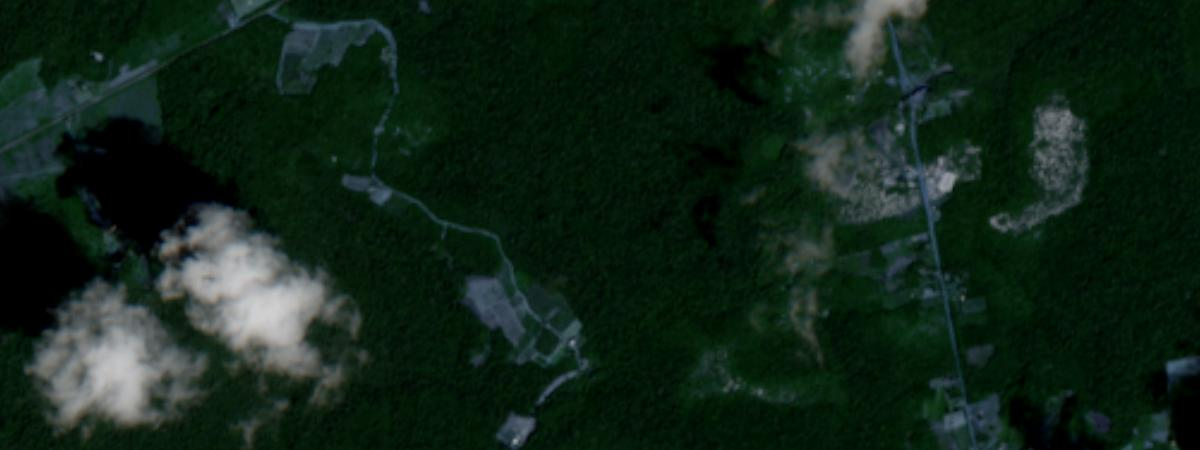

In [15]:
# displaying the new 4 bands imagery 
tile_rgb

In [12]:
# publish the extracted imagery with 4 bands to the portal
tile_rgb.save('s2_amazon_extent2', gis=gis3)

<Item title:"s2_amazon_extent2" type:Imagery Layer owner:sbanik>

The published imagery of the Amzaon rainforest is exported to an image file on disk for further processing.

In [17]:
raster_amazon = Raster("https://deldevd040.esri.com/server/rest/services/Hosted/s2_amazon_extent2/ImageServer")

In [18]:
# checking the extent, which shows it can be a bit different from the actual extent of the saved scene
raster_amazon.extent

{
  "xmin": -6589488.77526103,
  "ymin": -327024.09456122026,
  "xmax": -6586198.775678899,
  "ymax": -325144.0948000029,
  "spatialReference": {
    "wkid": 102100,
    "latestWkid": 3857
  }
}

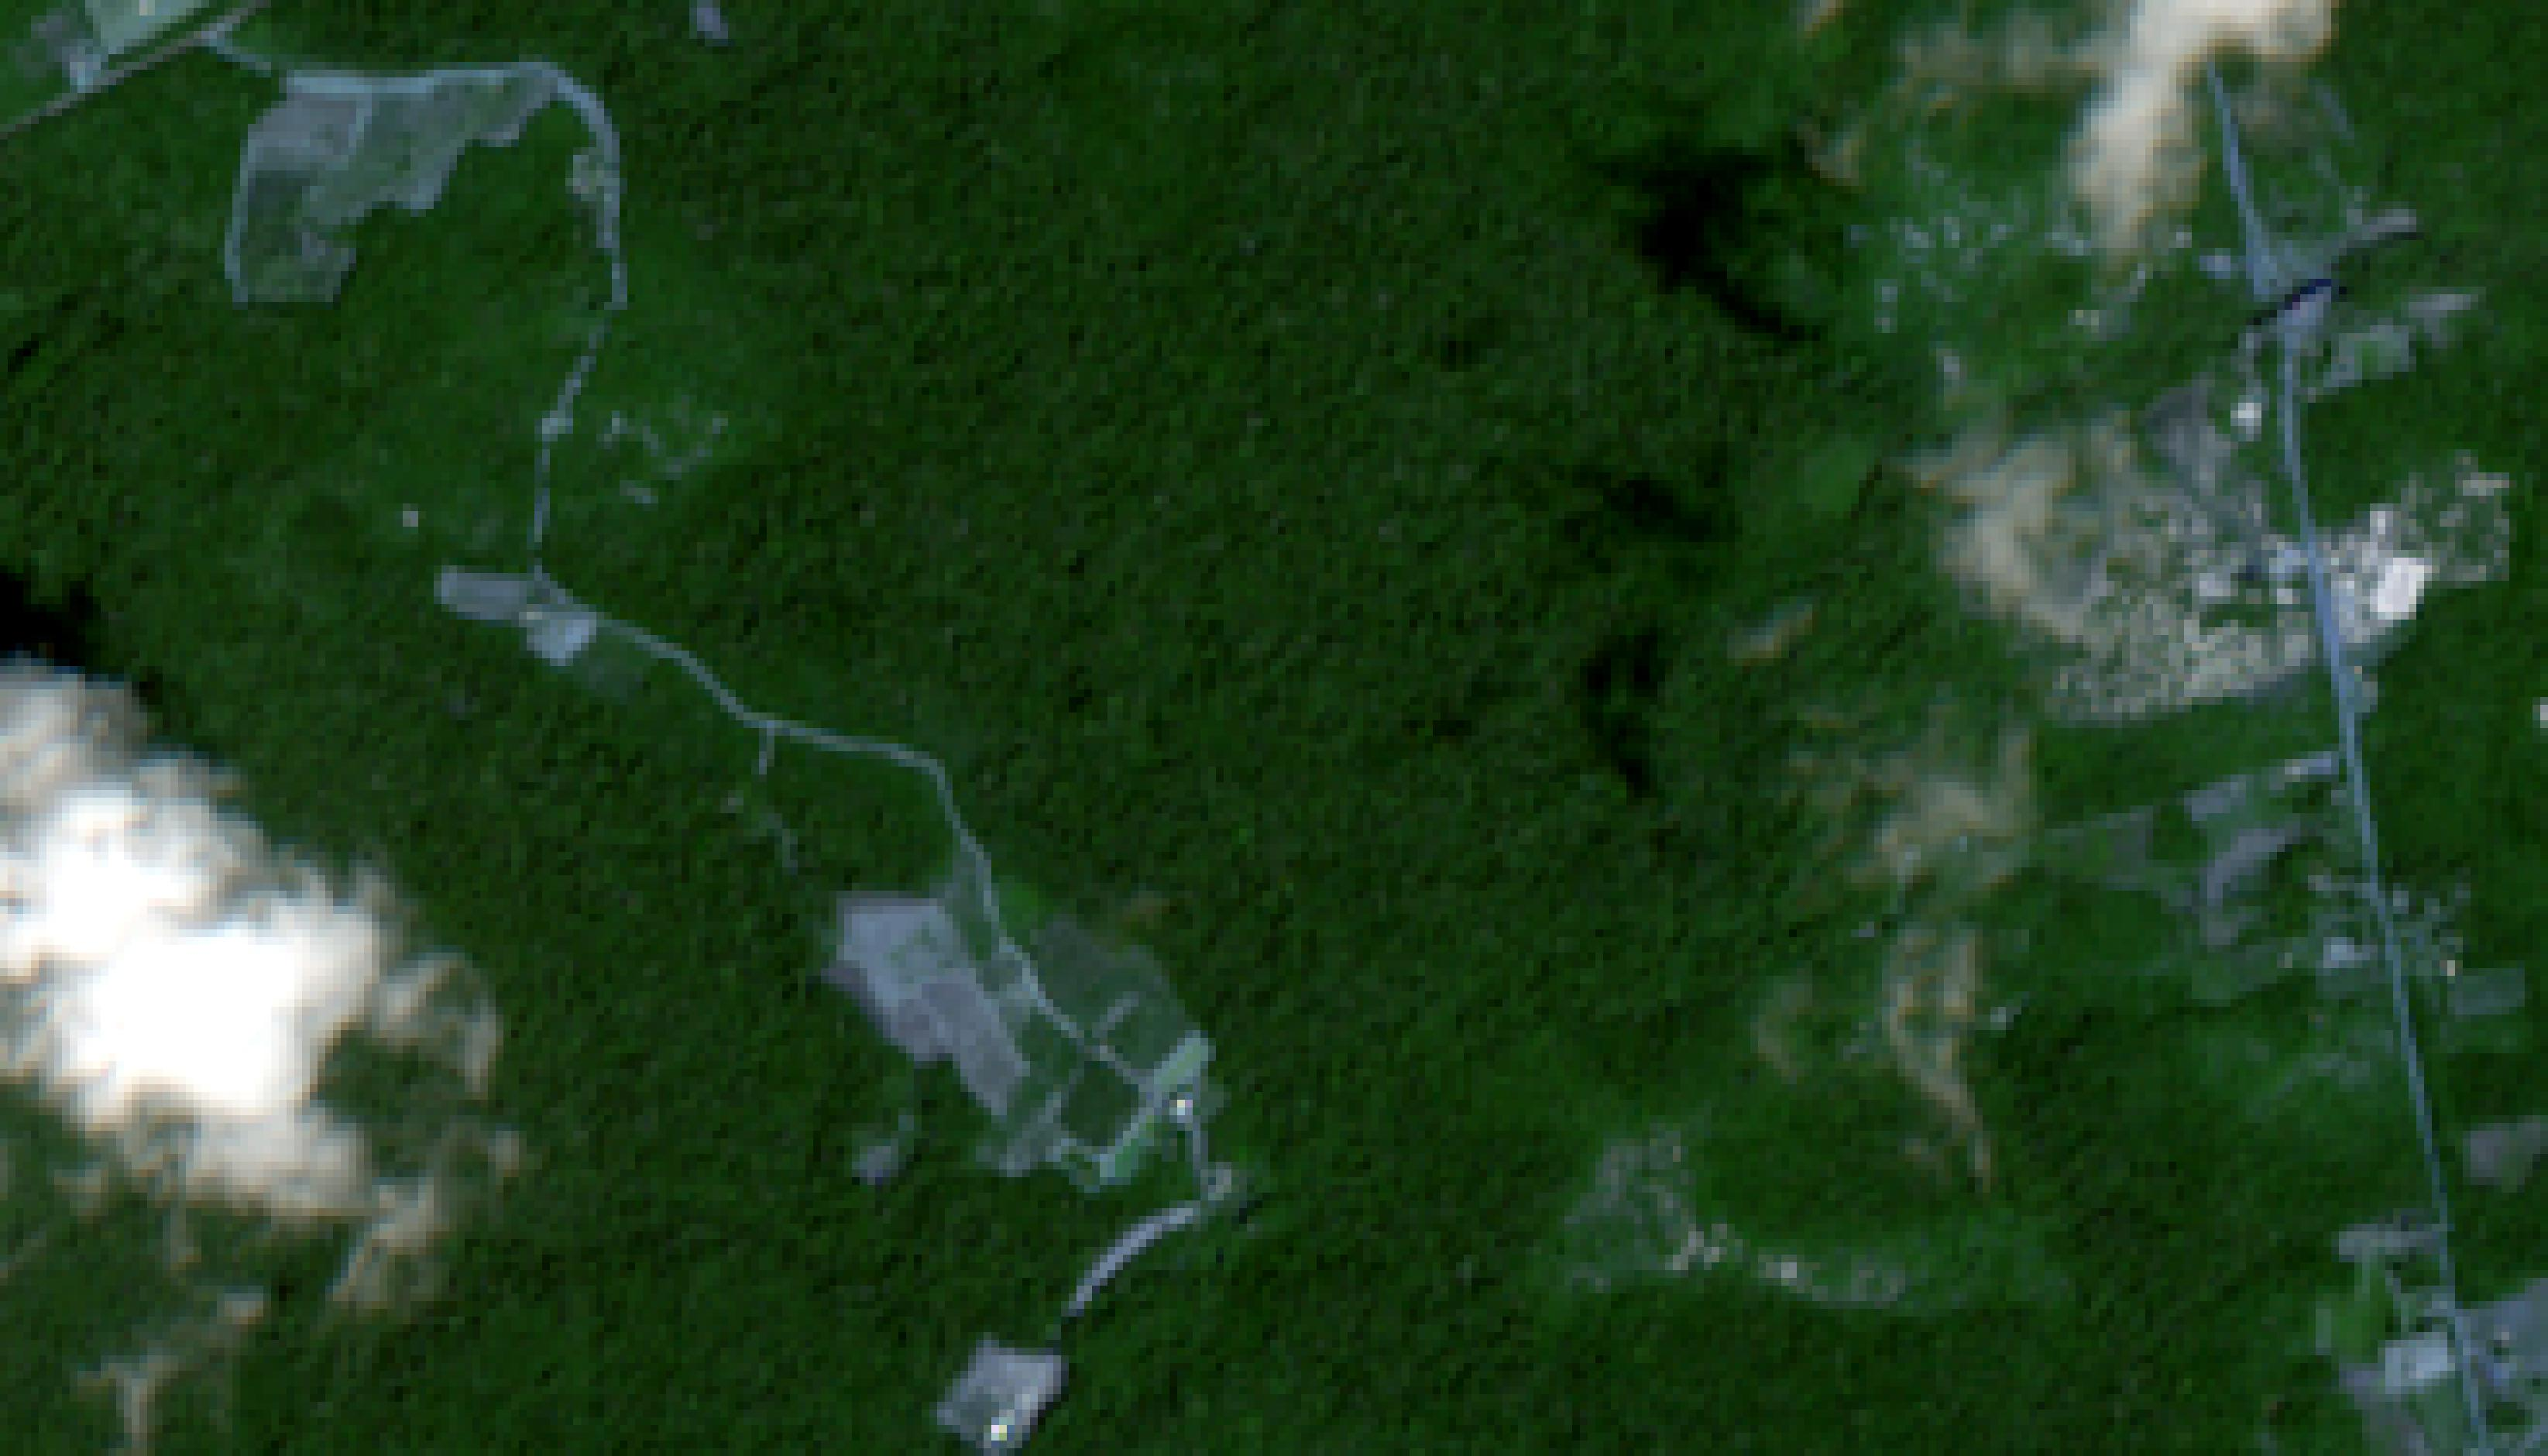

In [20]:
# visualizing the image 
raster_amazon.export_image(size=[3290,1880])

## Model Building <a class="anchor" id="9"></a>

The first part of model building consist of defining the preprocessors, using which the bands will be scaled before feeding into the model. 
The band names by convention uses the imagery name as follows: 

In [21]:
# get the imagery name to define the band names
raster_amazon.name

'Hosted/s2_amazon_extent2'

Here the imagery name is 'Hosted/s2_amazon_extent2', following which the name of the 4 bands are 'Hosted/s2_amazon_extent2', 'Hosted/s2_amazon_extent2_1', 'Hosted/s2_amazon_extent2_2' and 'Hosted/s2_amazon_extent2_3'. These bands are to be used for defining the preprocessors.   

### Data Preprocessing <a class="anchor" id="11"></a>

In [24]:
from sklearn.preprocessing import MinMaxScaler

The four bands are listed in the preprocessors for scaling, with the last item as the designated scaler as follows. 

In [35]:
preprocessors = [('Hosted/s2_amazon_extent2', 'Hosted/s2_amazon_extent2_1', 'Hosted/s2_amazon_extent2_2', 'Hosted/s2_amazon_extent2_3', MinMaxScaler())]

In [36]:
# Data is prepared for the mlmodel using the selected scene and the preprocessors
data = prepare_tabulardata(explanatory_rasters=[raster_amazon], preprocessors=preprocessors)

In [37]:
# visualization of the data to be processed by the model
data.show_batch()

,Hosted/s2_amazon_extent2,Hosted/s2_amazon_extent2_1,Hosted/s2_amazon_extent2_2,Hosted/s2_amazon_extent2_3
21558,821,720,384,2774
33723,819,691,406,2426
53715,818,705,374,2592
54885,822,760,386,2825
58826,817,729,386,2778


### Model Initialization <a class="anchor" id="12"></a>

Once the data is prepared an unuspervised model of k-means clustering from scikit-learn is used here for clustering the pixels into deforested areas and forested areas. Here the clustering model is passed inside MLModel as follows, with number of clusters as three in the parameters. 

In [38]:
from arcgis.learn import MLModel, prepare_tabulardata

In [39]:
model = MLModel(data, 'sklearn.cluster.KMeans', n_clusters=3, init='k-means++', random_state=43)

### Model Training <a class="anchor" id="14"></a>

In [40]:
# here model is trained which labels the pixels with the three classes
model.fit()

In [41]:
# the labelled pixels can be visualized as follows with the last column returning the predicted labels by the model 
model.show_results()

,Hosted/s2_amazon_extent2,Hosted/s2_amazon_extent2_1,Hosted/s2_amazon_extent2_2,Hosted/s2_amazon_extent2_3,prediction_results
11170,838,774,434,2539,1
18531,795,668,365,2575,1
21224,806,684,381,2861,1
35973,803,716,404,3280,1
59015,1166,1155,1288,2790,2


### Deforestation Clusters Prediction<a class="anchor" id="21"></a>

The trained model is now used to predict the clusters on the enitre selected scene from the Amazon rainforest. Here this is passed as the explanatory rasters, with prediction type as raster, and a local path is provided for the output.  

In [42]:
pred_new = model.predict(explanatory_rasters=[raster_amazon], prediction_type='raster',output_raster_path=r"C:\2021\2-February\unsupervised notebook\result5.tif")

## Result Visualization<a class="anchor" id="16"></a>

The resulting raster is now read back for visualization, with the predicted classes of deforested areas and forested areas from the scene.

In [51]:
raster_predict = Raster(r"C:\2021\2-February\unsupervised notebook\result5.tif")

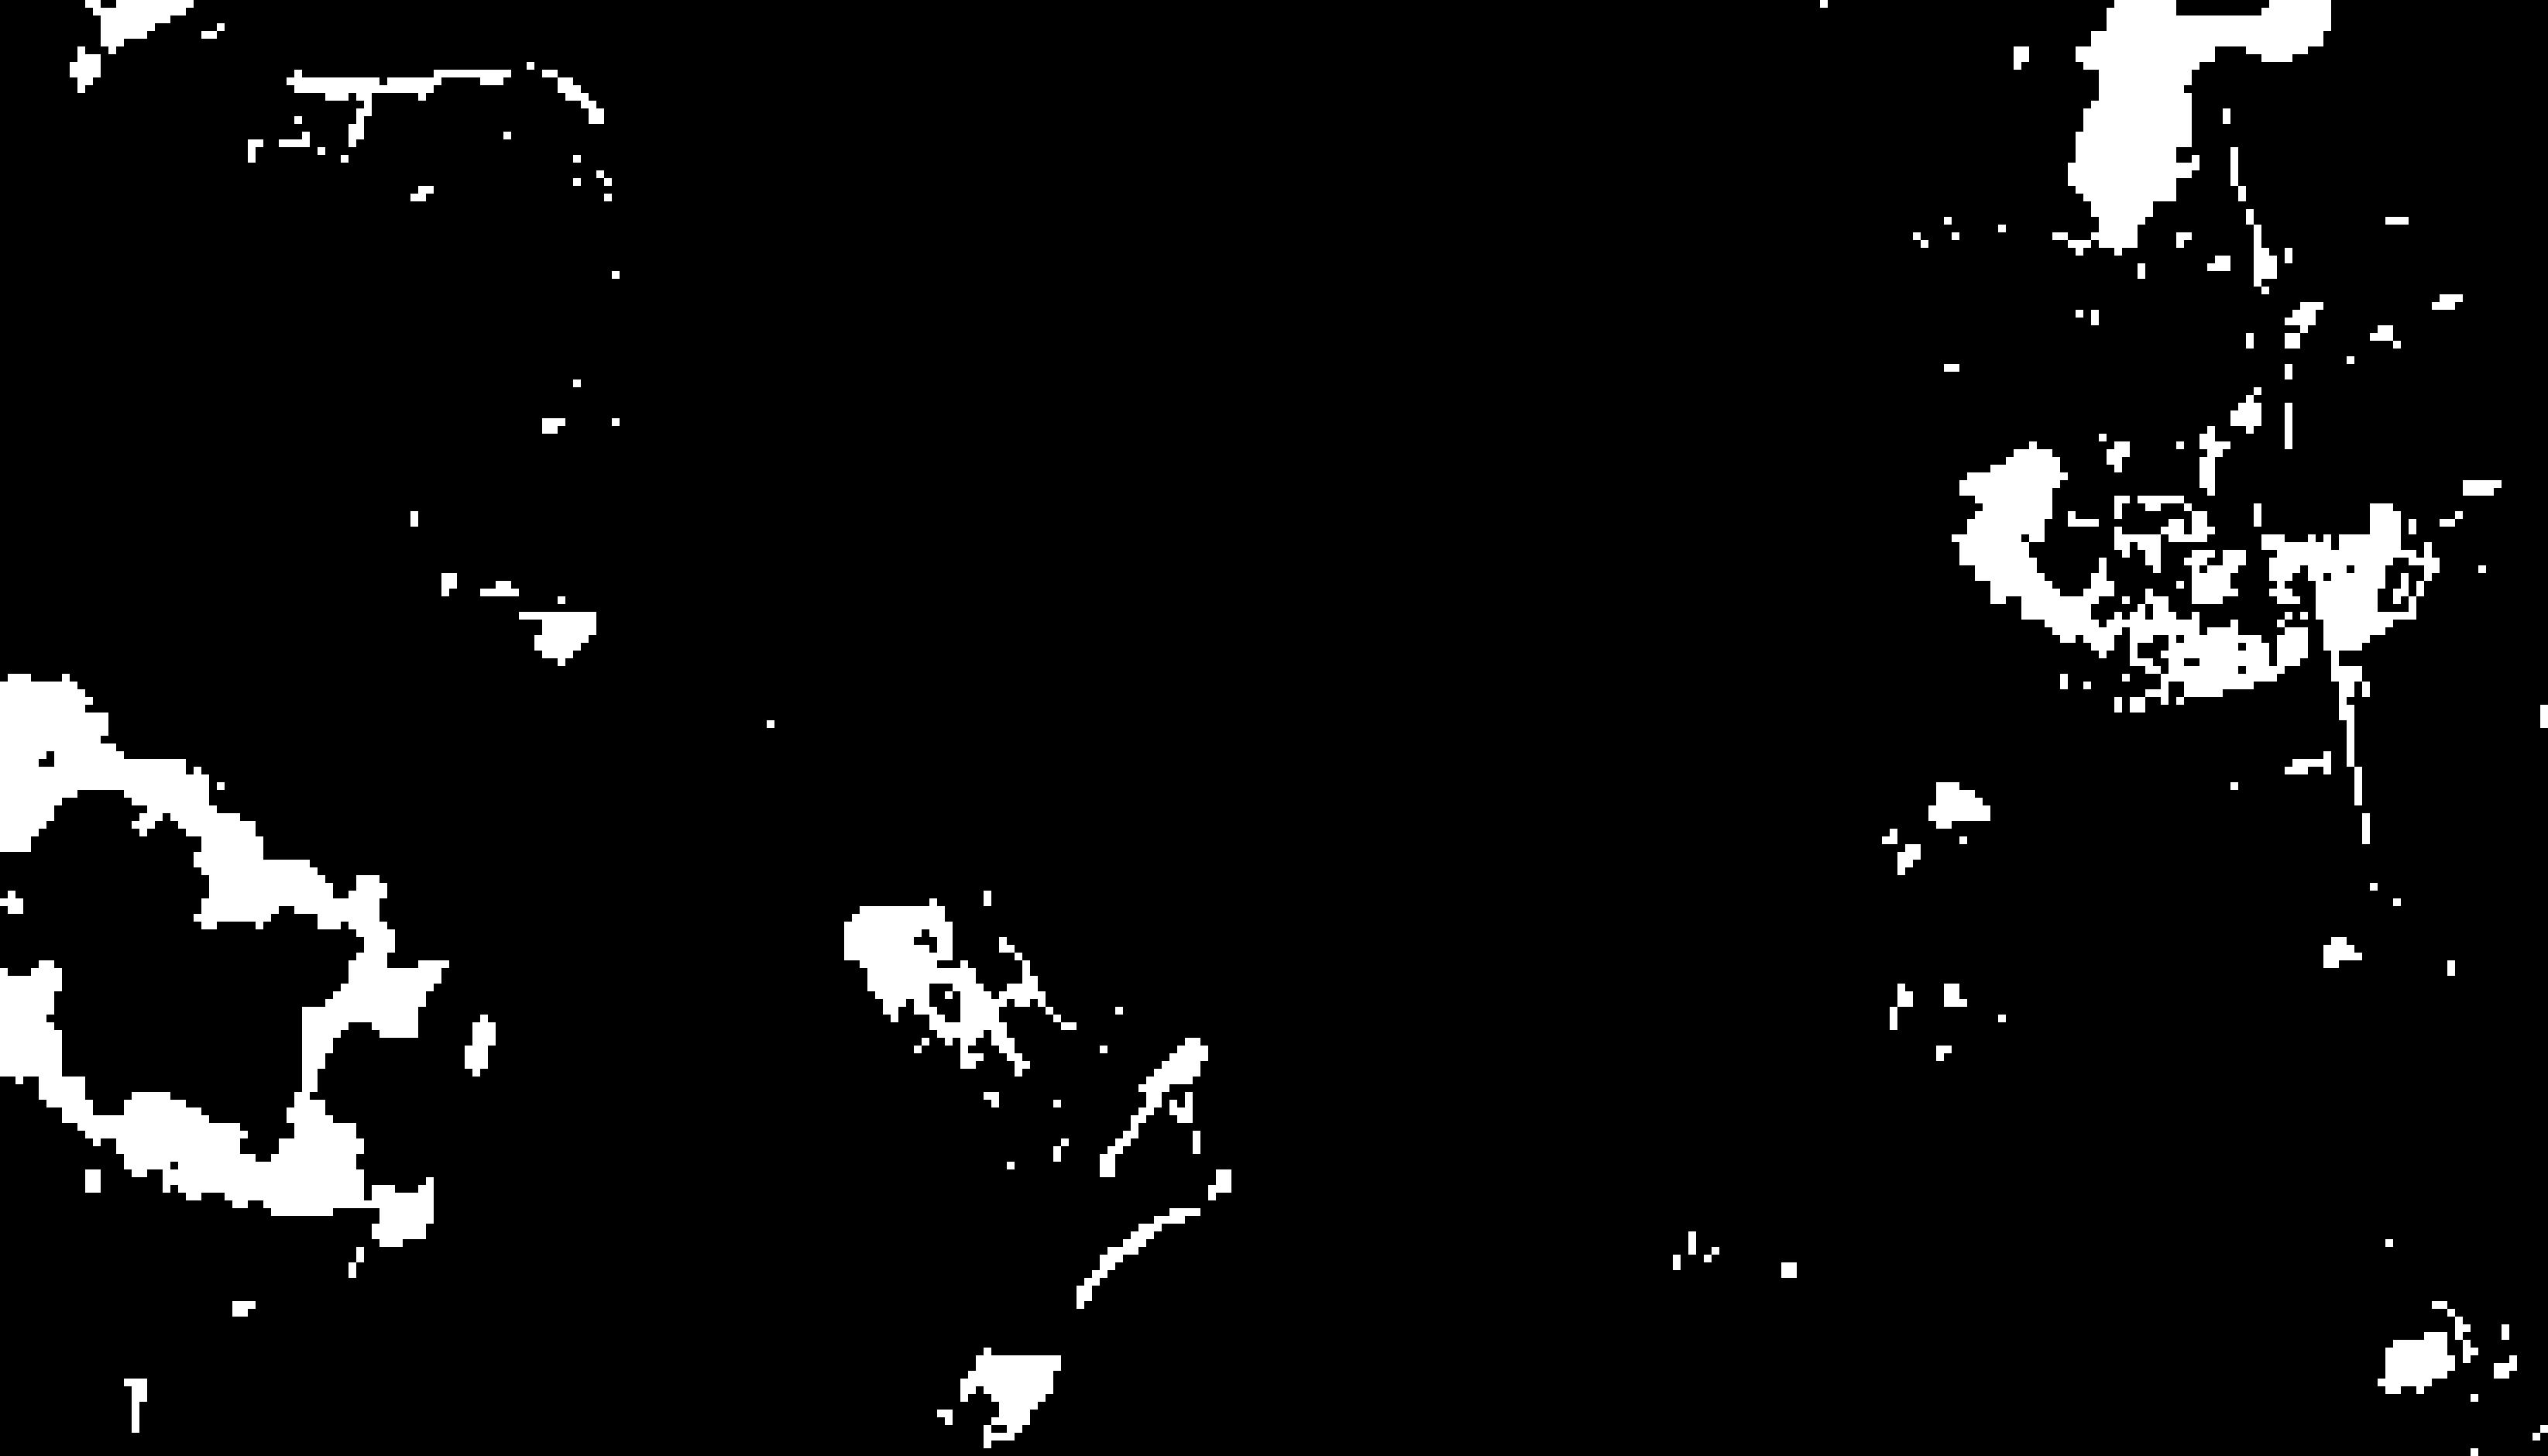

In [57]:
raster_predict.export_image(size=[3290,1880])

Here the model has correctly labelled the deforested areas in white, from the rest of the forested areas in black. There are also some clouds labelled as white pixels, which can be seperated out. 

The boundaries of the detected deforested areas could be further extracted into polygons using the convert raster to feature function  .

## Conclusion<a class="anchor" id="23"></a>

In this sample notebook we were able to detect deforestation in the Amazon rainforest using the unsupervised model of k-means clustering on sattelilte imagery. This was implemented via the MLModel framework, and thereby exhibited the aplication of the several unsupervised model from the scikit learn library on raster imagery.

### Summary of methods used <a class="anchor" id="24"></a>

| Method | Description | Examples |
| -| - |-|
| prepare_tabulardata| prepare data including imputation, normalization and train-test split  |prepare data ready for fitting a  MLModel 
| MLModel() | select the ML algorithm to be used for fitting  | any supervised and unsupervised models from scikit learn can be used
| model.fit() | train a model   | training the unsupervised model with sutiable input 
| model.score() | find the appropriate model metric of the trained model  | returns suitable value after training the unsupervised MLModel
| model.predict() | predict on a test set | predict values using the trained models on the trained data itself

### Data resources <a class="anchor" id="25"></a>

| Dataset | Source | Link |
| -| - |-|
| sat imagery| sentinel2  |https://registry.opendata.aws/sentinel-2/|